# Fitting Gaussian Mixture Models with EM

In this assignment you will
* implement the EM algorithm for a Gaussian mixture model
* apply your implementation to cluster images
* explore clustering results and interpret the output of the EM algorithm  

**Note to Amazon EC2 users**: To conserve memory, make sure to stop all the other notebooks before running this notebook.

## Import necessary packages

In [1]:
import graphlab as gl
import numpy as np
import matplotlib.pyplot as plt 
import copy
from scipy.stats import multivariate_normal

%matplotlib inline

## Implementing the EM algorithm for Gaussian mixture models

In this section, you will implement the EM algorithm. We will take the following steps:

- Create some synthetic data.
- Provide a log likelihood function for this model.
- Implement the EM algorithm.
- Visualize the progress of the parameters during the course of running EM.
- Visualize the convergence of the model.

### Dataset

To help us develop and test our implementation, we will generate some observations from a mixture of Gaussians and then run our EM algorithm to discover the mixture components. We'll begin with a function to generate the data, and a quick plot to visualize its output for a 2-dimensional mixture of three Gaussians.

Now we will create a function to generate data from a mixture of Gaussians model. 

In [2]:
def generate_MoG_data(num_data, means, covariances, weights):
    """ Creates a list of data points """
    num_clusters = len(weights)
    data = []
    for i in range(num_data):
        #  Use np.random.choice and weights to pick a cluster id greater than or equal to 0 and less than num_clusters.
        k = np.random.choice(len(weights), 1, p=weights)[0]

        # Use np.random.multivariate_normal to create data from this cluster
        x = np.random.multivariate_normal(means[k], covariances[k])

        data.append(x)
    return data

After specifying a particular set of clusters (so that the results are reproducible across assignments), we use the above function to generate a dataset.

In [3]:
# Model parameters
init_means = [
    [5, 0], # mean of cluster 1
    [1, 1], # mean of cluster 2
    [0, 5]  # mean of cluster 3
]
init_covariances = [
    [[.5, 0.], [0, .5]], # covariance of cluster 1
    [[1., .7], [0, .7]], # covariance of cluster 2
    [[.5, 0.], [0, .5]]  # covariance of cluster 3
]
init_weights = [1/4., 1/2., 1/4.]  # weights of each cluster

# Generate data
np.random.seed(4)
data = generate_MoG_data(100, init_means, init_covariances, init_weights)

**Checkpoint**: To verify your implementation above, make sure the following code does not return an error.

In [4]:
assert len(data) == 100
assert len(data[0]) == 2
print 'Checkpoint passed!'

Checkpoint passed!


In [5]:
data[0]

array([ 0.31845368,  5.03182099])

Now plot the data you created above. The plot should be a scatterplot with 100 points that appear to roughly fall into three clusters.

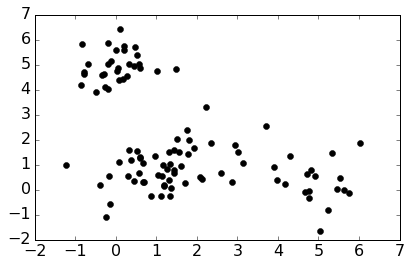

In [6]:
plt.figure()
d = np.vstack(data)
plt.plot(d[:,0], d[:,1],'ko')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

### Log likelihood 
We provide a function to calculate log likelihood for mixture of Gaussians. The log likelihood quantifies the probability of observing a given set of data under a particular setting of the parameters in our model. We will use this to assess convergence of our EM algorithm; specifically, we will keep looping through EM update steps until the log likehood ceases to increase at a certain rate.

In [7]:
def log_sum_exp(Z):
    """ Compute log(\sum_i exp(Z_i)) for some array Z."""
    return np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z))))

def loglikelihood(data, weights, means, covs):
    """ Compute the loglikelihood of the data for a Gaussian mixture model with the given parameters. """
    num_clusters = len(means)
    num_dim = len(data[0])
    
    ll = 0
    for d in data:
        
        Z = np.zeros(num_clusters)
        for k in range(num_clusters):
            
            # Compute (x-mu)^T * Sigma^{-1} * (x-mu)
            delta = np.array(d) - means[k]
            exponent_term = np.dot(delta.T, np.dot(np.linalg.inv(covs[k]), delta))
            
            # Compute loglikelihood contribution for this data point and this cluster
            Z[k] += np.log(weights[k])
            Z[k] -= 1/2. * (num_dim * np.log(2*np.pi) + np.log(np.linalg.det(covs[k])) + exponent_term)
            
        # Increment loglikelihood contribution of this data point across all clusters
        ll += log_sum_exp(Z)
        
    return ll

### Implementation

You will now complete an implementation that can run EM on the data you just created. It uses the `loglikelihood` function we provided above.

Fill in the places where you find ## YOUR CODE HERE. There are seven places in this function for you to fill in.

Hint: Some useful functions

* [multivariate_normal.pdf](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html): lets you compute the likelihood of seeing a data point in a multivariate Gaussian distribution.
* [np.outer](http://docs.scipy.org/doc/numpy/reference/generated/numpy.outer.html): comes in handy when estimating the covariance matrix from data.

In [8]:
def EM(data, init_means, init_covariances, init_weights, maxiter=1000, thresh=1e-4):
    
    # Make copies of initial parameters, which we will update during each iteration
    means = init_means[:]
    covariances = init_covariances[:]
    weights = init_weights[:]
    
    # Infer dimensions of dataset and the number of clusters
    num_data = len(data)
    num_dim = len(data[0])
    num_clusters = len(means)
    
    # Initialize some useful variables
    resp = np.zeros((num_data, num_clusters))
    ll = loglikelihood(data, weights, means, covariances)
    ll_trace = [ll]
    
    for i in range(maxiter):
        if i % 5 == 0:
            print("Iteration %s" % i)
        
        # E-step: compute responsibilities
        # Update resp matrix so that resp[j, k] is the responsibility of cluster k for data point j.
        # Hint: To compute likelihood of seeing data point j given cluster k, use multivariate_normal.pdf.
        for j in range(num_data):
            for k in range(num_clusters):
                # YOUR CODE HERE
                resp[j, k] = multivariate_normal.pdf(data[j], means[k], covariances[k]) * weights[k]
        row_sums = resp.sum(axis=1)[:, np.newaxis] # 'transposes' the array
        resp = resp / row_sums # normalize over all possible cluster assignments

        # M-step
        # Compute the total responsibility assigned to each cluster, which will be useful when 
        # implementing M-steps below. In the lectures this is called N^{soft}
        counts = np.sum(resp, axis=0)
        
        for k in range(num_clusters):
            
            # Update the weight for cluster k using the M-step update rule for the cluster weight, \hat{\pi}_k.
            # YOUR CODE HERE
            weights[k] = counts[k]/num_data #counts[k]/N is the total weight for cluster k
            
            # Update means for cluster k using the M-step update rule for the mean variables.
            # This will assign the variable means[k] to be our estimate for \hat{\mu}_k.
            weighted_sum = 0
            for j in range(num_data):
                # YOUR CODE HERE
                weighted_sum += resp[j,k] * data[j]
                #weighted_sum += weights[k] * data[j]
            # YOUR CODE HERE
            means[k] = weighted_sum/counts[k]
            
            # Update covariances for cluster k using the M-step update rule for covariance variables.
            # This will assign the variable covariances[k] to be the estimate for \hat{\Sigma}_k.
            weighted_sum = np.zeros((num_dim, num_dim))
            for j in range(num_data):
                # YOUR CODE HERE (Hint: Use np.outer on the data[j] and this cluster's mean)
                weighted_sum += resp[j, k] * np.outer(data[j] - means[k], data[j] - means[k])
            # YOUR CODE HERE
            covariances[k] = weighted_sum/counts[k]
          
        
        # Compute the loglikelihood at this iteration
        # YOUR CODE HERE
        ll_latest = loglikelihood(data, weights, means, covariances)
        ll_trace.append(ll_latest)
        
        # Check for convergence in log-likelihood and store
        if (ll_latest - ll) < thresh and ll_latest > -np.inf:
            break
        ll = ll_latest
    
    if i % 5 != 0:
        print("Iteration %s" % i)
    
    out = {'weights': weights, 'means': means, 'covs': covariances, 'loglik': ll_trace, 'resp': resp}

    return out

### Testing the implementation on the simulated data

Now we'll fit a mixture of Gaussians to this data using our implementation of the EM algorithm. As with k-means, it is important to ask how we obtain an initial configuration of mixing weights and component parameters. In this simple case, we'll take three random points to be the initial cluster means, use the empirical covariance of the data to be the initial covariance in each cluster (a clear overestimate), and set the initial mixing weights to be uniform across clusters.

In [9]:
np.random.seed(4)

# Initialization of parameters
chosen = np.random.choice(len(data), 3, replace=False)
initial_means = [data[x] for x in chosen]
initial_covs = [np.cov(data, rowvar=0)] * 3
initial_weights = [1/3.] * 3

# Run EM 
results = EM(data, initial_means, initial_covs, initial_weights)

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 25
Iteration 29


In [10]:
initial_means

[array([ 0.19570654,  5.73836612]),
 array([ 6.01348014,  1.87722666]),
 array([ 0.52699679,  5.37301739])]

In [12]:
np.sum(results['resp'], axis=1)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [13]:
results['covs']

[array([[ 0.29159814,  0.05482336],
        [ 0.05482336,  0.34636791]]), array([[ 0.36731703, -0.02567641],
        [-0.02567641,  0.6869906 ]]), array([[ 0.93623418,  0.3211622 ],
        [ 0.3211622 ,  0.65796505]])]

**Checkpoint**. For this particular example, the EM algorithm is expected to terminate in 30 iterations. That is, the last line of the log should say "Iteration 29". If your function stopped too early or too late, you should re-visit your code.

Our algorithm returns a dictionary with five elements: 
* 'loglik': a record of the log likelihood at each iteration
* 'resp': the final responsibility matrix
* 'means': a list of K means
* 'covs': a list of K covariance matrices
* 'weights': the weights corresponding to each model component

**Quiz Question**: What is the weight that EM assigns to the first component after running the above codeblock?

In [11]:
# Your code here
results['weights']

[0.29999973954173353, 0.17978342303905062, 0.52021683741921609]

**Quiz Question**: Using the same set of results, obtain the mean that EM assigns the second component. What is the mean in the first dimension?

In [12]:
# Your code here
results['means']

[array([ 0.01901541,  4.95191045]),
 array([ 4.93845455,  0.31997078]),
 array([ 1.25993305,  0.91227531])]

**Quiz Question**: Using the same set of results, obtain the covariance that EM assigns the third component. What is the variance in the first dimension?

In [13]:
# Your code here
results['covs']

[array([[ 0.29159814,  0.05482336],
        [ 0.05482336,  0.34636791]]), array([[ 0.36731703, -0.02567641],
        [-0.02567641,  0.6869906 ]]), array([[ 0.93623418,  0.3211622 ],
        [ 0.3211622 ,  0.65796505]])]

In [14]:
len(data[0])

2

In [15]:
results['covs'][2]

array([[ 0.93623418,  0.3211622 ],
       [ 0.3211622 ,  0.65796505]])

### Plot progress of parameters

One useful feature of testing our implementation on low-dimensional simulated data is that we can easily visualize the results. 

We will use the following `plot_contours` function to visualize the Gaussian components over the data at three different points in the algorithm's execution:

1. At initialization (using initial_mu, initial_cov, and initial_weights)
2. After running the algorithm to completion 
3. After just 12 iterations (using parameters estimates returned when setting `maxiter=12`)

In [16]:
import matplotlib.mlab as mlab
def plot_contours(data, means, covs, title):
    plt.figure()
    plt.plot([x[0] for x in data], [y[1] for y in data],'ko') # data

    delta = 0.025
    k = len(means)
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    X, Y = np.meshgrid(x, y)
    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        sigmax = np.sqrt(cov[0][0])
        sigmay = np.sqrt(cov[1][1])
        sigmaxy = cov[0][1]/(sigmax*sigmay)
        Z = mlab.bivariate_normal(X, Y, sigmax, sigmay, mean[0], mean[1], sigmaxy)
        plt.contour(X, Y, Z, colors = col[i])
        plt.title(title)
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()

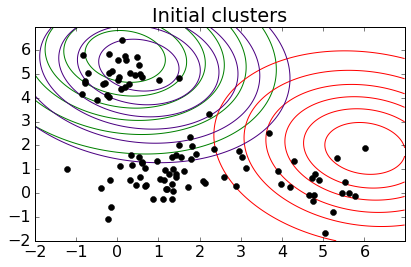

In [17]:
# Parameters after initialization
plot_contours(data, initial_means, initial_covs, 'Initial clusters')

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 25
Iteration 29


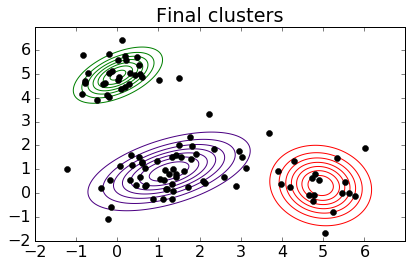

In [18]:
# Parameters after running EM to convergence
results = EM(data, initial_means, initial_covs, initial_weights)
plot_contours(data, results['means'], results['covs'], 'Final clusters')

Fill in the following code block to visualize the set of parameters we get after running EM for 12 iterations.

Iteration 0
Iteration 5
Iteration 10
Iteration 11


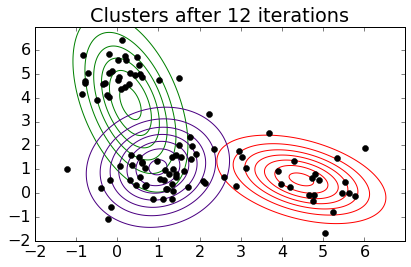

In [19]:
# YOUR CODE HERE
results = EM(data, initial_means, initial_covs, initial_weights, maxiter=12)

plot_contours(data, results['means'], results['covs'], 'Clusters after 12 iterations')

**Quiz Question**: Plot the loglikelihood that is observed at each iteration. Is the loglikelihood plot monotonically increasing, monotonically decreasing, or neither [multiple choice]? 

In [20]:
results = EM(data, initial_means, initial_covs, initial_weights)

# YOUR CODE HERE
loglikelihoods = results['loglik']

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 25
Iteration 29


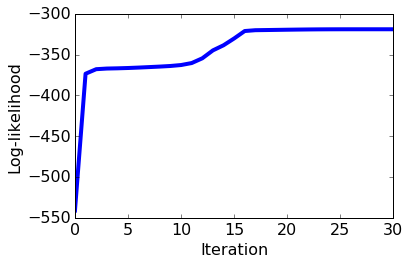

In [21]:
plt.plot(range(len(loglikelihoods)), loglikelihoods, linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

## Fitting a Gaussian mixture model for image data

Now that we're confident in our implementation of the EM algorithm, we'll apply it to cluster some more interesting data. In particular, we have a set of images that come from four categories: sunsets, rivers, trees and forests, and cloudy skies. For each image we are given the average intensity of its red, green, and blue pixels, so we have a 3-dimensional representation of our data. Our goal is to find a good clustering of these images using our EM implementation; ideally our algorithm would find clusters that roughly correspond to the four image categories.

To begin with, we'll take a look at the data and get it in a form suitable for input to our algorithm. The data are provided in SFrame format:

In [22]:
images = gl.SFrame('images.sf')
#gl.canvas.set_target('ipynb')
gl.canvas.set_target('browser')
import array
images['rgb'] = images.pack_columns(['red', 'green', 'blue'])['X4']
images.show()

This non-commercial license of GraphLab Create is assigned to tolurotimibabalola@gmail.com and will expire on December 29, 2016. For commercial licensing options, visit https://turi.com/buy/.


[INFO] graphlab.cython.cy_server: GraphLab Create v1.10.1 started. Logging: C:\Users\ROLEXJ~1\AppData\Local\Temp\graphlab_server_1469600463.log.0


Canvas is accessible via web browser at the URL: http://localhost:54783/index.html
Opening Canvas in default web browser.


We need to come up with initial estimates for the mixture weights and component parameters. Let's take three images to be our initial cluster centers, and let's initialize the covariance matrix of each cluster to be diagonal with each element equal to the sample variance from the full data. As in our test on simulated data, we'll start by assuming each mixture component has equal weight. 

This may take a few minutes to run.

In [23]:
np.random.seed(1)

# Initalize parameters
init_means = [images['rgb'][x] for x in np.random.choice(len(images), 4, replace=False)]
cov = np.diag([images['red'].var(), images['green'].var(), images['blue'].var()])
init_covariances = [cov, cov, cov, cov]
init_weights = [1/4., 1/4., 1/4., 1/4.]

# Convert rgb data to numpy arrays
img_data = [np.array(i) for i in images['rgb']]  

# Run our EM algorithm on the image data using the above initializations. 
# This should converge in about 125 iterations
out = EM(img_data, init_means, init_covariances, init_weights)

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 25
Iteration 30
Iteration 35
Iteration 40
Iteration 45
Iteration 50
Iteration 55
Iteration 60
Iteration 65
Iteration 70
Iteration 75
Iteration 80
Iteration 85
Iteration 90
Iteration 95
Iteration 100
Iteration 105
Iteration 110
Iteration 115
Iteration 118


The following sections will evaluate the results by asking the following questions:

* **Convergence**: How did the log likelihood change across iterations? Did the algorithm achieve convergence?
* **Uncertainty**: How did cluster assignment and uncertainty evolve?
* **Interpretability**: Can we view some example images from each cluster? Do these clusters correspond to known image categories?

### Evaluating convergence

Let's start by plotting the log likelihood at each iteration - we know that the EM algorithm guarantees that the log likelihood can only increase (or stay the same) after each iteration, so if our implementation is correct then we should see an increasing function.

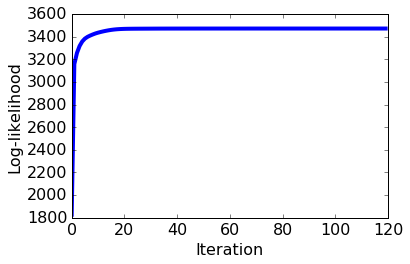

In [24]:
ll = out['loglik']
plt.plot(range(len(ll)),ll,linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

The log likelihood increases so quickly on the first few iterations that we can barely see the plotted line. Let's plot the log likelihood after the first three iterations to get a clearer view of what's going on:

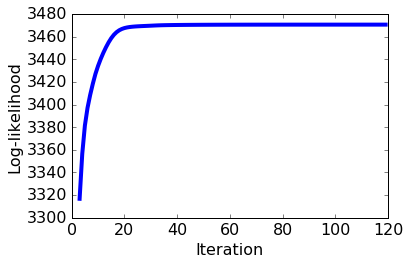

In [25]:
plt.figure()
plt.plot(range(3,len(ll)),ll[3:],linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

### Evaluating uncertainty

Next we'll explore the evolution of cluster assignment and uncertainty. Remember that the EM algorithm represents uncertainty about the cluster assignment of each data point through the responsibility matrix. Rather than making a 'hard' assignment of each data point to a single cluster, the algorithm computes the responsibility of each cluster for each data point, where the responsibility corresponds to our certainty that the observation came from that cluster. 

We can track the evolution of the responsibilities across iterations to see how these 'soft' cluster assignments change as the algorithm fits the Gaussian mixture model to the data; one good way to do this is to plot the data and color each point according to its cluster responsibilities. Our data are three-dimensional, which can make visualization difficult, so to make things easier we will plot the data using only two dimensions, taking just the [R G], [G B] or [R B] values instead of the full [R G B] measurement for each observation.


In [26]:
import colorsys
def plot_responsibilities_in_RB(img, resp, title):
    N, K = resp.shape
    
    HSV_tuples = [(x*1.0/K, 0.5, 0.9) for x in range(K)]
    RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
    
    R = img['red']
    B = img['blue']
    resp_by_img_int = [[resp[n][k] for k in range(K)] for n in range(N)]
    cols = [tuple(np.dot(resp_by_img_int[n], np.array(RGB_tuples))) for n in range(N)]

    plt.figure()
    for n in range(len(R)):
        plt.plot(R[n], B[n], 'o', c=cols[n])
    plt.title(title)
    plt.xlabel('R value')
    plt.ylabel('B value')
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()

To begin, we will visualize what happens when each data has random responsibilities.

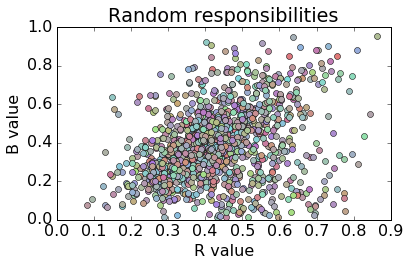

In [27]:
N, K = out['resp'].shape
random_resp = np.random.dirichlet(np.ones(K), N)
plot_responsibilities_in_RB(images, random_resp, 'Random responsibilities')

We now use the above plotting function to visualize the responsibilites after 1 iteration. 

Iteration 0


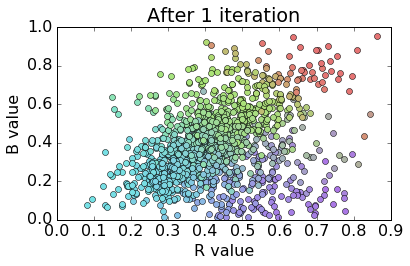

In [28]:
out = EM(img_data, init_means, init_covariances, init_weights, maxiter=1)
plot_responsibilities_in_RB(images, out['resp'], 'After 1 iteration')

We now use the above plotting function to visualize the responsibilites after 20 iterations. We will see there are fewer unique colors; this indicates that there is more certainty that each point belongs to one of the four components in the model. 

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 19


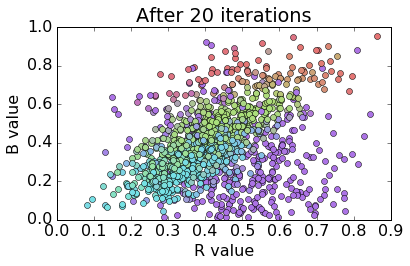

In [29]:
out = EM(img_data, init_means, init_covariances, init_weights, maxiter=20)
plot_responsibilities_in_RB(images, out['resp'], 'After 20 iterations')

Plotting the responsibilities over time in [R B] space shows a meaningful change in cluster assignments over the course of the algorithm's execution. While the clusters look significantly better organized at the end of the algorithm than they did at the start, it appears from our plot that they are still not very well separated. We note that this is due in part our decision to plot 3D data in a 2D space; everything that was separated along the G axis is now "squashed" down onto the flat [R B] plane. If we were to plot the data in full [R G B] space, then we would expect to see further separation of the final clusters.  We'll explore the cluster interpretability more in the next section.

### Interpreting each cluster

Let's dig into the clusters obtained from our EM implementation. Recall that our goal in this section is to cluster images based on their RGB values. We can evaluate the quality of our clustering by taking a look at a few images that 'belong' to each cluster. We hope to find that the clusters discovered by our EM algorithm correspond to different image categories - in this case, we know that our images came from four categories ('cloudy sky', 'rivers', 'sunsets', and 'trees and forests'), so we would expect to find that each component of our fitted mixture model roughly corresponds to one of these categories.

If we want to examine some example images from each cluster, we first need to consider how we can determine cluster assignments of the images from our algorithm output. This was easy with k-means - every data point had a 'hard' assignment to a single cluster, and all we had to do was find the cluster center closest to the data point of interest. Here, our clusters are described by probability distributions (specifically, Gaussians) rather than single points, and our model maintains some uncertainty about the cluster assignment of each observation.

One way to phrase the question of cluster assignment for mixture models is as follows: how do we calculate the distance of a point from a distribution? Note that simple Euclidean distance might not be appropriate since (non-scaled) Euclidean distance doesn't take direction into account.  For example, if a Gaussian mixture component is very stretched in one direction but narrow in another, then a data point one unit away along the 'stretched' dimension has much higher probability (and so would be thought of as closer) than a data point one unit away along the 'narrow' dimension. 

In fact, the correct distance metric to use in this case is known as [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance). For a Gaussian distribution, this distance is proportional to the square root of the negative log likelihood. This makes sense intuitively - reducing the Mahalanobis distance of an observation from a cluster is equivalent to increasing that observation's probability according to the Gaussian that is used to represent the cluster. This also means that we can find the cluster assignment of an observation by taking the Gaussian component for which that observation scores highest. We'll use this fact to find the top examples that are 'closest' to each cluster.

__Quiz Question:__ Calculate the likelihood (score) of the first image in our data set (`images[0]`) under each Gaussian component through a call to `multivariate_normal.pdf`.  Given these values, what cluster assignment should we make for this image? 

In [30]:
out['means']

[array([ 0.54860824,  0.64789051,  0.75691943]),
 array([ 0.4269232 ,  0.45963776,  0.46530014]),
 array([ 0.34733324,  0.38959621,  0.28831338]),
 array([ 0.47812035,  0.37882543,  0.33411632])]

In [31]:
out['covs']

[array([[ 0.01916168,  0.01246942,  0.00358258],
        [ 0.01246942,  0.01028619,  0.00555783],
        [ 0.00358258,  0.00555783,  0.00606585]]),
 array([[ 0.01008673,  0.00903642,  0.00913248],
        [ 0.00903642,  0.00965271,  0.01114966],
        [ 0.00913248,  0.01114966,  0.01532925]]),
 array([[ 0.00776037,  0.00729637,  0.00546288],
        [ 0.00729637,  0.0098123 ,  0.0061564 ],
        [ 0.00546288,  0.0061564 ,  0.01001514]]),
 array([[ 0.01728282,  0.00486226, -0.00268984],
        [ 0.00486226,  0.01913078,  0.01837771],
        [-0.00268984,  0.01837771,  0.0355894 ]])]

In [32]:
images[0]

{'blue': 0.29739183218564663,
 'folder': 'sunsets',
 'green': 0.2545700932661306,
 'image': Height: 194px
 Width: 259px
 Channels: 3,
 'path': '/data/coursera/images/sunsets/ANd9GcSN4TPL6_XoTvZeg3-15UhGnWAwjhbxQLjTNiCpWIqMyzq27xIdlg.jpg',
 'red': 0.4032234842076981,
 'rgb': [0.4032234842076981, 0.2545700932661306, 0.29739183218564663]}

In [33]:
multivariate_normal.pdf(img_data[0], out['means'][0], out['covs'][0])

2.4811274490925664e-07

In [34]:
multivariate_normal.pdf(img_data[0], out['means'][1], out['covs'][1])

2.957577120225087e-09

In [35]:
multivariate_normal.pdf(img_data[0], out['means'][2], out['covs'][2])

0.33145962010512919

In [36]:
multivariate_normal.pdf(img_data[0], out['means'][3], out['covs'][3])

16.527159591135263

Now we calculate cluster assignments for the entire image dataset using the result of running EM for 20 iterations above:

In [37]:
means = out['means']
covariances = out['covs']
rgb = images['rgb']
N = len(images)
K = len(means)

assignments = [0]*N
probs = [0]*N

for i in range(N):
    # Compute the score of data point i under each Gaussian component:
    p = np.zeros(K)
    for k in range(K):
        # YOUR CODE HERE (Hint: use multivariate_normal.pdf and rgb[i])
        p[k] = multivariate_normal.pdf(rgb[i], means[k], covariances[k])
        
    # Compute assignments of each data point to a given cluster based on the above scores:
    # YOUR CODE HERE
    assignments[i] = np.argmax(p)
    
    # For data point i, store the corresponding score under this cluster assignment:
    # YOUR CODE HERE
    ass = np.argmax(p)
    probs[i] = multivariate_normal.pdf(rgb[i], means[ass], covariances[ass])

assignments = gl.SFrame({'assignments':assignments, 'probs':probs, 'image': images['image']})

We'll use the 'assignments' SFrame to find the top images from each cluster by sorting the datapoints within each cluster by their score under that cluster (stored in `probs`). We can plot the corresponding images in the original data using show().

Create a function that returns the top 5 images assigned to a given category in our data (HINT: use the GraphLab Create function `topk(column, k)` to find the k top values according to specified column in an SFrame).

In [38]:
assignments.head(2)

assignments,probs,image
3,16.5271595911,Height: 194 Width: 259
3,8.08362978275,Height: 194 Width: 259


In [64]:
def get_top_images(assignments, cluster, k=5):
    # YOUR CODE HERE
    images_in_cluster = assignments[assignments['assignments'] == cluster]
    top_images = images_in_cluster.topk('probs', k)
    return top_images['image']

In [45]:
gl.canvas.set_target('browser')
foo = assignments[assignments['assignments'] == 3]
bar = foo.topk('probs', 5)
bar['image'].show()

Canvas is updated and available in a tab in the default browser.


Use this function to show the top 5 images in each cluster.

In [65]:
gl.canvas.set_target('browser')
for component_id in range(4):
    get_top_images(assignments, component_id).show()

Canvas is accessible via web browser at the URL: http://localhost:51737/index.html
Opening Canvas in default web browser.
Canvas is accessible via web browser at the URL: http://localhost:51737/index.html
Opening Canvas in default web browser.
Canvas is accessible via web browser at the URL: http://localhost:51737/index.html
Opening Canvas in default web browser.
Canvas is accessible via web browser at the URL: http://localhost:51737/index.html
Opening Canvas in default web browser.


These look pretty good! Our algorithm seems to have done a good job overall at 'discovering' the four categories that from which our image data was drawn. It seems to have had the most difficulty in distinguishing between rivers and cloudy skies, probably due to the similar color profiles of images in these categories; if we wanted to achieve better performance on distinguishing between these categories, we might need a richer representation of our data than simply the average [R G B] values for each image.

__Quiz Question:__ Which of the following images are *not* in the list of top 5 images in the first cluster?

![Images](chosen_images.png)